# Modelling the response of a Raspberry Pi camera to collimated light

This notebook specifically addresses the question of whether we can come up with an analytic model of the correction, which might remove or reduce the need for calibration.  See the other notebook for details of the different calibration methods we used, and more general analysis of the compensation.  The first couple of cells mostly deal with loading the images - this is more or less identical to the other notebook, except that only a single "run" is considered, which is the data taken using the neopixel jig.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from picam_raw_analysis.extract_raw_image import load_raw_image
import sys
import os
import numbers
import scipy.ndimage as ndimage

%matplotlib inline
matplotlib.rc('text', usetex=False)
matplotlib.rc('font',family='serif', serif=['tex gyre termes', 'DejaVu Serif'], size=8)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('savefig', pad_inches=0)
manuscript_linewidth=4.774 # this saves re-scaling things afterwards

%load_ext autoreload

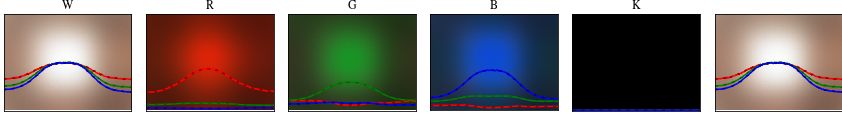

In [5]:
from matplotlib.colors import LinearSegmentedColormap

def bin(image, b=2):
    """Bin bxb squares of an image together"""
    w,h = image.shape[:2]
    new_shape = (w//b, b, h//b, b)
    if len(image.shape) > 2:
        new_shape += image.shape[2:]
    if w % b != 0 or h % b != 0:
        print("Warning: pixels are being dropped from the binned image!")
        image = image[:w - (w%b), :h - (h%b), ...]
    return image.reshape(new_shape).mean(axis=1).mean(axis=2)

def load_raw_image_and_bin(filename):
    """Load an image from the raw data in a jpeg file, and return a binned version."""
    pi_bayer_array = load_raw_image(filename)
    image = pi_bayer_array.array - np.array([16,32,16])[np.newaxis,np.newaxis,:] # correct for the zero offset in the raw data
    return bin(image, 16)
def load_run(folder, illuminations):
    """Load the R,G,B,W calibration images and any additional images."""
    output = {}
    for k, rgb in illuminations.items():
        output[k] = load_raw_image_and_bin(os.path.join(folder, "capture_r{}_g{}_b{}.jpg".format(*rgb)))
    for f in os.listdir(folder):
        if f.startswith("additional_image_"):
            output[f[17:-4]] = load_raw_image_and_bin(os.path.join(folder, f))
    return output
    
# These are some utility functions that label the plots nicely
def col_titles(axes, titles):
    for topax, title in zip(axes, titles):
        topax.set_title(title)
def wrgb_col_titles(axes):
    col_titles(axes, ["white", "red", "green", "blue", "black"][:len(axes)])
def row_titles(axes, titles, offset=(0,0)):
    for ax, title in zip(axes, titles):
        ax.annotate(title, xy=(0, 0.5), xytext=offset,
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='left', va='center', rotation="vertical")
        
def imshow_with_section(ax, image, clip=True, whitepoint=255., section=True):
    """Convert an image to 8 bit and display it in the axes.
    
    if clip==True (default) pixels are constrained to 0-255, to avoid overflow.
    if section==True (default) line graphs are overlaid for R,G,B sections through the image.
    ax should be a matplotlib Axes instance into which we plot, and image is the NxMx3 
    array that we are displaying.
    """
    if isinstance(whitepoint, numbers.Number):
        normalised_image = image/whitepoint*255.
    elif whitepoint == "max" or whitepoint is np.max:
        normalised_image = image / np.max(image) * 255.
    elif whitepoint == "channel_max":
        normalised_image = image / np.max(image, axis=(0,1)) * 255.
        
    if clip:
        clipped_image = image.copy()
        clipped_image[clipped_image<0] = 0
        clipped_image[clipped_image>255] = 255
    else:
        clipped_image = image
    ax.imshow(clipped_image.astype(np.uint8), origin="bottom")
    x = np.arange(image.shape[1])
    h = image.shape[0]
    if section:
        for i, col in enumerate(["red","green","blue"]):
            ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color=col)
            ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color="dark"+col, dashes=(2,4))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
        
# Load the data:
illuminations = {"W":(255,255,255), "R":(255,0,0), "G":(0,255,0), "B":(0,0,255), "K":(0,0,0)}
# Load the images where a solid colour was displayed across the whole screen
data_folder = "../data/monitor_and_50mm_lens/neopixel_jig/"
run = load_run(data_folder, illuminations)
run_backup = {im_name: image.copy() for im_name, image in run.items()}

def plot_run(run, norm=None):
    if norm is None:
        norm = 1
    elif norm == "centre":
        norm = 255./np.max(run['W'], axis=(0,1))
    elif norm == "white":
        norm = 255./run['W']
    
    f, ax = plt.subplots(1, 6, tight_layout=True, figsize=(12,3))
    norm_centre = 255. / np.max(run['W'], axis=(0,1))
    for i,k in enumerate(["W","R","G","B","K","colour_wheels"]):
        try:
            imshow_with_section(ax[i], run[k]*norm)
            ax[i].set_title(k)
        except KeyError:
            imshow_with_section(ax[i], run['W']*norm)
    return f, ax

f, ax = plot_run(run, norm="centre")

In the other notebook, we analysed the RGB images produced under different illuminations, to figure out the effect of the Chief Ray Angle (CRA) compensation.  This results in some empirical correction matrices which are per-pixel (or at least spatially varying).  If we can model this sufficiently well as an effect that is purely geometric, we end up needing far fewer parameters - this might well help us to reduce noise and make calibration easier, or even unnecessary.  It would also be really satisfying to understand where the effect comes from.

A minimal model might consist of light passing first through a Bayer filter, then through a lenslet, then being focused on the light-sensitive area of a pixel.  The offset between light sensitive area and lenslet is probably what varies the most across the sensor.  This means:
* The efficiency will drop off as the light sensitive region moves away from the centre of the lenslets.  The sharpness of this cut-off will be set by the convolution of the focal spot (which may be differently shaped for different wavelengths) and the shape of the light sensitive region.
* Crosstalk will pick up once the focused spot overlaps with adjacent pixels, which have different colour filters on them.  The Bayer pattern probably has a subtle influence on which colours bleed into each other.
* The effect needn't be rotationally symmetric (the pixels are on a square grid - that is not isotropic) but it probably is at least a little bit symmetrical.

The Bayer pattern has twice as many green pixels as red or blue.  This means that each green pixel's four nearest neighboars are two red and two blue, and each R/B pixel has four green nearest neighbours.  If we consider the next-nearest-neighbours (i.e. diagonal), each green pixel has four green neighbours, and each R/B pixel has two each of R and B.

Looking at the uncorrected images from our test camera, the first thing to note is the different rates with which the intensity falls off as we move away from the centre: 

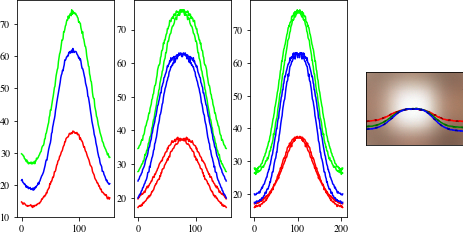

In [14]:
fig, ax = plt.subplots(1,4, figsize=(8,4))
w, h = run['W'].shape[:2]
colours = {k: tuple(v/255. for v in col) for k, col in illuminations.items()} #extract colours for the plot
for i, k in enumerate(["R", "G", "B"]):
    col = colours[k]
    ax[0].plot(np.diagonal(run[k][:,:,i]), color=col)
    ax[1].plot(run[k][:,h//2,i], color=col)
    ax[1].plot(run[k][:,h//2,i][::-1], color=col)
    ax[2].plot(run[k][w//2,:,i], color=col)
    ax[2].plot(run[k][w//2,:,i][::-1], color=col)
imshow_with_section(ax[3], run['W']/np.max(run['W'], axis=(0,1))*255)

Let's repeat those plots, starting in the centre and working out radially.  In order to define the "centre" we use a background-subtracted centre of mass measurement.  This should be more reliable than just finding the coordinates of the maximum intensity, because the latter is very sensitive to noise when the "peak" is broad (as is the case here).

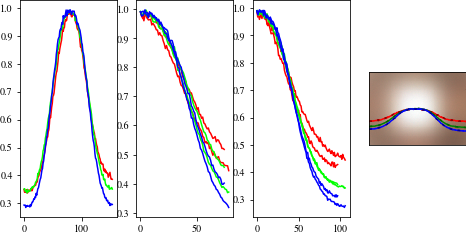

In [18]:
import scipy.ndimage

# We do a background-subtracted centre of mass measurement to find
# the "centre" (i.e. brightest point) of the image.
background_subtracted = np.sum(run['W'], axis=2)
background_subtracted -= np.max(background_subtracted)*0.9
background_subtracted[background_subtracted < 0] = 0
centroid = scipy.ndimage.measurements.center_of_mass(background_subtracted)
cx, cy = np.round(centroid).astype(int)

fig, ax = plt.subplots(1,4, figsize=(8,4))
w, h = run['W'].shape[:2]
for i, k in enumerate(["R", "G", "B"]):
    col = colours[k]
    m = np.max(run[k][:,:,i])
    ax[0].plot(np.diagonal(run[k][:,:,i]/m, offset=cy-cx), color=col)
    ax[1].plot(run[k][cx:0:-1,cy,i]/m, color=col)
    ax[1].plot(run[k][cx::,cy,i]/m, color=col)
    ax[2].plot(run[k][cx,cy:0:-1,i]/m, color=col)
    ax[2].plot(run[k][cx,cy:,i]/m, color=col)
imshow_with_section(ax[3], run['W']/np.max(run['W'], axis=(0,1))*255)

From the two middle plots, it's clear that the pattern is close to symmetrical, but not exactly.  It looks like there is a non-uniform background (maybe a gradient across the sensor).  I wouldn't like to speculate as to whether that is due to something electrical or just some stray light.  I did try with the jig in a few orientations, and it didn't seem to matter.

# Radial symmetry
The most naiive assumption would be that the effect only depends on the angle between the designed incidence of the ray and the actual incident angle (assumed here to be constant across the sensor).  This probably ought to be radially symmetric (at least until you account for the pixel grid, etc. etc.).  We can test this hypothesis by plotting the intensity vs radius - the top plots do this directly, the bottom plots are histograms of the same thing, which show the distribution more clearly.

In [26]:
from scipy import stats

def channel_to_hist2d(r, channel):
    """Calculate a 2D histogram of an image against r and I
    
    Arguments:
        r: a 2D array of radial coordinate values
        channel: a 2D array of intensity values
        
    Returns:
        density, xe, ye
        density is the histogram, as a 2D array.  xe is a 1D array
        of bin edges in r, ye is the bin edges in intensity.
    """
    density, xe, ye = np.histogram2d(r.ravel(), channel.ravel(), 
                                     (np.arange(np.max(r)+1), np.arange(np.max(channel)+1)))
    return density, xe, ye

def hist2d_to_i_vs_r(density, xe, ye):
    """Turn a 2D histogram into mean and standard deviation
    
    Given the output of ``channel_to_hist2d``, calculate the mean and sd of
    the intensity values for each bin in r.
    
    Returns:
        r, I_mean, I_sd
        radial coordinates (bin left edges), intensity values, and standard deviations.
    """
    r = xe[:-1]
    I = (ye[:-1] + ye[1:])/2.0
    I_mean = np.sum(density * I, axis=1)/np.sum(density, axis=1)
    I_sd = np.sqrt(np.sum(density * (I - I_mean[:,np.newaxis])**2, axis=1)/np.sum(density, axis=1))
    return r, I_mean, I_sd

x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)
f, ax = plt.subplots(2,3, figsize=(9,6))
colour_names = {'R': 'red', 'G': 'green', 'B': 'blue'}

for i, k in enumerate("RGB"):
    col = colour_names[k]
    channel = run[k][:,:,i]
    # Upper plots: one dot for each pixel (crude but effective!)
    ax[0,i].plot(np.ravel(r), np.ravel(channel), '.', color=col)
    
    # Lower plots: make a 2D histogram
    density, xe, ye = channel_to_hist2d(r, channel)
    ax[1,i].pcolormesh(xe, ye, density.T, cmap=col.capitalize()+"s")

The top row shows the data plotted as points in intensity vs r, which are too close together to really see the details.  The lower row is a 2D histogram, which gives essentially the same thing, but it's easier to distinguish the structure.

If we take radial symmetry (about the maximum rather than about the centre) as our model, we can look at the residuals as a 2D image - this seems to suggest that the problem is just that it's bright at the bottom.  This is the axis along which I'd be most likely to suspect stray light, but it's also the one where you'd be most likely to get electrical effects, I think.  We might be able to learn more if we repeat the experiment in the dark, with the camera tilted, or with the camera flipped 180 degrees.

Next, can we fit a simple function to this?  A 2D Gaussian would seem to me to be the most obvious choice, and the code below will attempt to do a nonlinear optimisation to fit each colour channel with a 2D Gaussian.

Red channel has RMS amplitude 21.5, with residual amplitude 1.2 (5)%
Green channel has RMS amplitude 41.9, with residual amplitude 2.1 (5)%
Blue channel has RMS amplitude 33.2, with residual amplitude 1.9 (6)%


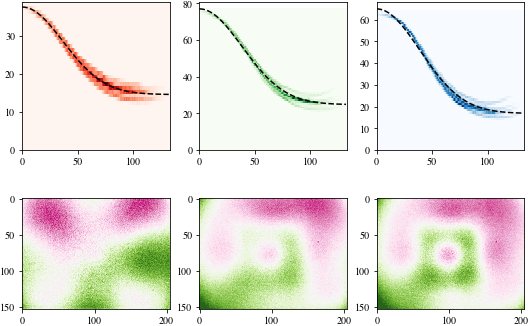

In [37]:
from scipy import optimize

f, ax = plt.subplots(2,3, figsize=(9,6))

def gaussian(x, sd, peak, background):
    """A 1D Gaussian centred on the origin"""
    return np.exp(-x**2/2/sd**2)*(peak - background) + background

for i, k in enumerate("RGB"):
    col = colour_names[k]
    channel = run[k][:,:,i]
    # This is the same histogram in Intensity, r calculated above
    density, xe, ye = channel_to_hist2d(r, channel)
    # Plot the histogram in the background
    ax[0,i].pcolormesh(xe, ye, density.T, cmap=col.capitalize()+"s")
    # Extract the mean intensity for each radial bin
    rs, I_mean, I_sd = hist2d_to_i_vs_r(density, xe, ye)
    # Plot the mean +/- SD
    #for s in [-1, 1]:
    #    ax[0,i].plot(rs, I_mean + s*I_sd, color=col)
    #ax[0,i].fill_between(rs, mean_i_vs_r - sd_i_vs_r, mean_i_vs_r + sd_i_vs_r, color=col)
    
    # Fit a gaussian and plot it on top of the histogram
    popt, pcov = optimize.curve_fit(gaussian, rs, I_mean, (40, I_mean.max(), 0))
    
    ax[0,i].plot(fitx, gaussian(fitx, *popt), '--', color="black")
    
    model = np.interp(r.ravel(), np.arange(len(I_mean)), I_mean).reshape(r.shape)
    model = np.interp(r.ravel(), np.arange(len(I_mean)), gaussian(rs, *popt)).reshape(r.shape)
    im = ax[1,i].imshow((channel - model)/np.max(model), cmap="PiYG", vmin=-0.08, vmax=0.08)
    
    rms_amplitude = np.mean(channel**2)**0.5
    rms_residuals = np.mean((channel-model)**2)**0.5
    print("{} channel has RMS amplitude {:.1f}, with residual amplitude {:.1f} ({:.0f})%".format(
            col.capitalize(), rms_amplitude, rms_residuals, rms_residuals/rms_amplitude*100.))
#plt.colorbar(im)

The Gaussian fit looks really good on the red channel, but it's much less convincing on green and blue - while the residuals arean't much stronger, they do have a noticable square structure in the centre.  To get an idea of goodness-of-fit, we can look at the residuals; the RMS amplitude of the R,G,B residuals is about 5% of the RMS amplisude of the channel.

I wonder if what we need is the convolution of a square and a gaussian?  That would fit with the model of a focal spot shifting around on a square pixel.  The next cell extends the fit with some extra parameters that result a Gaussian that's spread out by a square.

In [38]:
from scipy import optimize

x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)

def gaussian(x, y, sd, sw, sh, peak, background, cx=cx, cy=cy):
    """A 1D Gaussian centred on the origin"""
    dx = np.abs(x - cx) - sw/2
    dx[dx < 0] = 0
    dy = np.abs(y - cy) - sh/2
    dy[dy < 0] = 0
    return np.exp(-(dx**2 + dy**2)/2/sd**2)*(peak - background) + background
           
def residuals_for(channel):
    def residuals(p):
        return ((channel - gaussian(x, y, *p))**2).ravel()
    return residuals

f, ax = plt.subplots(3,3, figsize=(9,9))
for i, k in enumerate("RGB"):
    col = colour_names[k]
    channel = run[k][:,:,i]
    density, xe, ye = channel_to_hist2d(r, channel)
    ax[0,i].pcolormesh(xe, ye, density.T, cmap=col.capitalize()+"s")
    #ax[0,i].fill_between(np.arange(len(mean_i_vs_r)), mean_i_vs_r - sd_i_vs_r, mean_i_vs_r + sd_i_vs_r, color=col)
    
    res = optimize.least_squares(residuals_for(channel), 
                                 (40, 0, 0, channel.max(), 0, cx, cy),
                                 bounds=((0, 0, 0, 0, 0, 0, 0),
                                         (np.inf, w, h, np.inf, np.inf, w, h)))
    popt = res.x
    print("Optimal parameters: SD {}, square {}x{}, peak {}, background {}, centre ({},{})".format(*popt))
    
    # Render the fitted function and calculate the same 2D histogram we did for the measured correction
    gchannel = gaussian(x, y, *popt)
    gdensity, xe, ye = channel_to_hist2d(r, gchannel)
    rs, gI_mean, gI_sd = hist2d_to_i_vs_r(gdensity, xe, ye)
    # Plot the mean +/- SD as a line, on top of the 2D histogram
    for s in [-1, 1]:
        ax[0,i].plot(rs, gI_mean + s*gI_sd, color="black")
    
    #ax[0,i].plot(r.ravel(), gaussian(x, y, *popt).ravel(), '--', color="gray")
    ax[1,i].imshow(gaussian(x, y, *popt))
    im = ax[2,i].imshow((channel - gchannel)/np.max(channel), cmap="PiYG", vmin=-0.08, vmax=0.08)
    
    rms_amplitude = np.mean(channel**2)**0.5
    rms_residuals = np.mean((channel-gchannel)**2)**0.5
    print("{} channel has RMS amplitude {:.1f}, with residual amplitude {:.1f} ({:.0f})%".format(
            col.capitalize(), rms_amplitude, rms_residuals, rms_residuals/rms_amplitude*100.))
    print("")

Optimal parameters: SD 36.995363395433955, square 4.676347596695326e-37x3.4380452629608325, peak 37.463354984450234, background 14.443002162500408, centre (83.22894483103435,101.10435565600572)
Red channel has RMS amplitude 21.5, with residual amplitude 0.9 (4)%

Optimal parameters: SD 33.39954665291826, square 12.270803749661878x12.675897524631035, peak 74.77315874417157, background 25.651156561196842, centre (82.26999293279277,97.02353080800661)
Green channel has RMS amplitude 41.9, with residual amplitude 1.6 (4)%

Optimal parameters: SD 31.48505282539424, square 17.234548444010862x17.006455788471413, peak 62.43978374994447, background 18.103348385020556, centre (81.49793931383364,96.72857766264892)
Blue channel has RMS amplitude 33.2, with residual amplitude 1.4 (4)%



This looks like we've gone a bit further, and pushed the residuals to higher order - though the RMS amplitude has only gone from about 5-6% down to 4%.  The remaining residuals look like they could probably be modelled quite well by a smooth function, like a sum of polynomials.

In [28]:
from scipy import optimize

x, y = np.meshgrid(range(w), range(h), indexing="ij", sparse=True)
r = np.sqrt((x-cx)**2 + (y-cy)**2)

def gaussian(x, y, sd, sw, sh, peak, background, cx=cx, cy=cy):
    """A 1D Gaussian centred on the origin"""
    dx = np.abs(x - cx) - sw/2
    dx[dx < 0] = 0
    dy = np.abs(y - cy) - sh/2
    dy[dy < 0] = 0
    return np.exp(-(dx**2 + dy**2)/2/sd**2)*(peak - background) + background
           
def residuals_for(channel):
    def residuals(p):
        return ((channel - gaussian(x, y, *p))**2).ravel()
    return residuals



def Poly2Fit(im_in):


    lines,points = im_in.shape
    
    max_w = float(max(lines,points))
    
    lb2=lines/max_w/2.
    pb2=points/max_w/2.
    xax = np.linspace(-pb2,pb2,points)
    yax = np.linspace(-lb2,lb2,lines)
    
    [x,y] = np.meshgrid(xax,yax)

    #Linearise data
    A=im_in.flatten()
    A = np.transpose(np.asmatrix(A))
    x=x.flatten()
    y=y.flatten()

    order=np.zeros([1,21]);

    X,_ = np.meshgrid(order,x);
    X[:,0] = np.ones(x.size)
    X[:,1] = x
    X[:,2] = y
    X[:,3] = x**2
    X[:,4] = x*y
    X[:,5] = y**2
    X[:,6] = x**3
    X[:,7] = x**2*y
    X[:,8] = x*y**2
    X[:,9] = y**3
    X[:,10] = x**4
    X[:,11] = x**3*y
    X[:,12] = x**2*y**2
    X[:,13] = x*y**3
    X[:,14] = y**4
    X[:,15] = x**5
    X[:,16] = x**4*y
    X[:,17] = x**3*y**2
    X[:,18] = x**2*y**3
    X[:,19] = x*y**4
    X[:,20] = y**5
    
    # Legendre
    #X[:,0] = np.ones(x.size)
    #X[:,1] = 1.7321*x
    #X[:,2] = 1.7321*y
    #X[:,3] = 3.3541*x**2-1.1180
    #X[:,4] = 3*x*y
    #X[:,5] = 3.3541*y**2-1.1180
    #X[:,6] = 6.6144*x**3-3.9686*x
    #X[:,7] = 5.8095*x**2*y-1.9365*y
    #X[:,8] = 5.8095*x*y**2-1.9365*x
    #X[:,9] = 6.6144*y**3-3.9686*y
    #X[:,10] = 13.125*x**4-11.25*x**2 + 1.125
    #X[:,11] = 11.4564*x**3*y-6.8739*x*y
    #X[:,12] = 11.25*x**2*y**2-3.75*x**2-3.75*y**2 + 1.25
    #X[:,13] = 11.4564*x*y**3-6.8739*x*y
    #X[:,14] = 13.125*y**4-11.25*y**2 + 1.125
    #X[:,15] = 26.1184*x**5-29.0205*x**3 + 6.2187*x
    #X[:,16] = 22.7332*x**4*y-19.4856*x**2*y + 1.9486*y
    #X[:,17] = 22.1853*x**3*y**2-7.3951*x**3-13.3112*x*y**2 + 4.4371*x
    #X[:,18] = 22.1853*x**2*y**3-7.3951*y**3-13.3112*x**2*y + 4.4371*y
    #X[:,19] = 22.7332*x*y**4-19.4856*x*y**2 + 1.9486*x
    #X[:,20] = 26.1184*y**5-29.0205*y**3 + 6.2187*y
    # Square Zernicke
    #X[:,1] = 1.7321*x
    #X[:,2] = 1.7321*y
    #X[:,3] = 2.3717*x**2 + 2.3717*y**2-1.5811
    #X[:,4] = 3*x*y
    #X[:,5] = 2.3717*x**2-2.3717*y**2
    #X[:,6] = 4.3649*x**2*y + 4.3649*y**3-4.0739*y
    #X[:,7] = 84.3649*x**3 + 4.3649*x*y**2-4.0739*x
    #X[:,8] = 3.8337*x**2*y-4.9697*y**3 + 1.7039*y
    #X[:,9] = 4.9697*x**3-3.8337*x*y**2-1.7039*x
    #X[:,10] = 4.8104*x**4 + 9.6208*x**2*y**2 + 4.8104*y**4-7.3302*x**2-7.3302*y**2 + 1.8936
    #X[:,11] = 9.2808*x**4-7.9550*x**2-9.2808*y**4 + 7.9550*y**2
    #X[:,12] = 8.1009*x**3*y + 8.1009*x*y**3-9.7211*x*y
    #X[:,13] = 7.9368*x**4-5.8311*x**2*y**2 + 7.9368*y**4-4.8593*x**2-4.8593*y**2 + 0.7127
    #X[:,14] = 8.1009*x**3*y-8.1009*x*y**3

    
    X=np.asmatrix(X)
    XT=np.transpose(X)

    #Use orthogonal decomposition to apply linear least squares fitting to the data set
    Q,R = np.linalg.qr(XT*X)
    iXTX = np.linalg.inv(R)*np.transpose(Q)
    
    beta = iXTX*XT*A

    #calculate fitted image
    Im = X*beta
    Im = Im.reshape([lines,points])
    return beta,Im


#Polynomial fit to residual

f, ax = plt.subplots(2,3, figsize=(9,6))
for i, col in enumerate(["red", "green", "blue"]):
    channel = binned_images[i+1][:,:,i]
    
    res = optimize.least_squares(residuals_for(channel), 
                                 (40, 0, 0, channel.max(), 0, cx, cy),
                                 bounds=((0, 0, 0, 0, 0, 0, 0),
                                         (np.inf, w, h, np.inf, np.inf, w, h)))
    popt = res.x
    print("Optimal parameters: SD {}, square {}x{}, peak {}, background {}, centre ({},{})".format(*popt))
    imf = gaussian(x, y, *popt)
    beta, Im = Poly2Fit(channel-imf)
    ax[0,i].imshow(imf+Im)
    im = ax[1,i].imshow((channel - imf - Im)/np.max(channel), cmap="PiYG", vmin=-0.08, vmax=0.08)
    
    rms_poly = np.mean(  np.asarray((channel - imf - Im).flatten())**2  )/np.max(channel)
    rms_wo_poly = np.mean(  np.asarray((channel - imf).flatten())**2  )/np.max(channel)
    print("RMS intentsity as percentage of channel maximum:")
    print("Without polynomial fit:\t %.1f%%"%(100*rms_wo_poly))
    print("With polynomial fit:\t %0.2f%%"%(100*rms_poly))
    
#Just fitting the polynomials was rubbish
    
#f, ax = plt.subplots(3,3, figsize=(9,6))
#for i, col in enumerate(["red", "green", "blue"]):
#    channel = binned_images[i+1][:,:,i]
#    beta, Im = Poly2Fit(channel)
#    ax[0,i].imshow(channel)
#    ax[1,i].imshow(Im)
#    im = ax[2,i].imshow((channel-Im)/np.max(channel), cmap="PiYG", vmin=-0.08, vmax=0.08)

Optimal parameters: SD 38.1969548013, square 4.03930269598e-22x4.14653660629, peak 36.0215883722, background 13.661917117, centre (87.8929755487,106.167157762)
RMS intentsity as percentage of channel maximum:
Without polynomial fit:	 3.8%
With polynomial fit:	 0.44%
Optimal parameters: SD 33.370809391, square 14.9872512565x13.0444199699, peak 72.79571583, background 24.8028443763, centre (87.2365916665,101.619654732)
RMS intentsity as percentage of channel maximum:
Without polynomial fit:	 5.6%
With polynomial fit:	 0.43%
Optimal parameters: SD 31.3669552771, square 19.5177774774x17.0648033366, peak 62.4536331685, background 18.030769794, centre (86.0667962541,100.849869415)
RMS intentsity as percentage of channel maximum:
Without polynomial fit:	 4.5%
With polynomial fit:	 0.40%


For obvious reason the residuals get better if you do a high order polynomial fit on what is left. The final RMS residual is about 0.4% instead of about 4-5%, by adding an extra 21 variables!

Current version is just plain polynomials. We also tried Square Zernike and 2D Legendre. Maybe this is a bad idea!

It might be interesting to include a couple of linear terms in the initial nonlinear fit, so that if there is a background that looks like a gradient, it could be taken out at the same time as the Gaussian (doing both simultaneously would possibly affect the centre position of the Gaussian, and so could result in smaller residuals and lower high-order polynomial coefficients).

The conclusion of all this is that, while we can analytically describe the correction to some extent, our equation has enough free parameters that it doesn't remove the need for calibration data and can't really be described as a "model".  If you need to generate a correction for a new lens and don't have a suitable calibration jig, I recommend re-using our calibration data to get the colour unmixing data, and simply imaging a white wall or similar to get the white normalisation.  Smoothing this image is almost certainly a good idea, as it will make the process much more forgiving to any little imperfections you might have in your image.